In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import networkx as nx
import re
import pickle
from itertools import combinations

In [3]:
from matplotlib.colors import ListedColormap
from matplotlib.cm import ScalarMappable
import matplotlib as mpl

In [11]:
from sklearn.tree import DecisionTreeClassifier, export_text, _tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.datasets import fetch_openml, make_classification
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, matthews_corrcoef

In [12]:
from ucimlrepo import fetch_ucirepo, list_available_datasets
from pmlb import fetch_data, classification_dataset_names

In [13]:
from psyke import Extractor, Clustering, EvaluableModel
from psyke.utils.logic import pretty_theory

In [14]:
import shap

In [15]:
from wittgenstein import RIPPER

In [16]:
import warnings
warnings.filterwarnings("ignore")

In [17]:
%run graph_building.py
%run parsing_rules.py

# CLINICAL BENCHMARKS

## PIMA INDIANS DATASET

In [14]:
cond_type = "relevance"#"relevance"#"impurity"
rule_type = "relevance"

In [15]:
nfolds = 5
outer_cv = StratifiedKFold(n_splits=nfolds, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [16]:
# import data
df_name = "PIMA"
df = pd.read_csv(f"LLM-outputs/{df_name}.csv")
df["target"] = df["Outcome"].astype("str")
feat_names = df.columns[:np.where(np.array(df.columns)=="Outcome")[0][0]]
X = df[feat_names].values
y = df["target"].values

In [17]:
# generating data for LLM
for rr, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    train, test = df.iloc[train_idx][list(feat_names) + ["target"]], df.iloc[test_idx][list(feat_names) + ["target"]]
    pd.concat((train, test)).to_csv(f"LLM-outputs/{df_name}_CV{rr}.csv", index = False) 

### LLM

In [22]:
adj_all = np.zeros((len(feat_names), len(feat_names)))
for rr in range(5):
    df = pd.read_csv(f"LLM-outputs/{df_name}_CV{rr}.csv") 
    train = df.loc[:round(len(df)*0.8)]
    train["target"] = train["target"].astype("str")
    rules_df = pd.read_csv(f"LLM-outputs/{df_name}_res_CV{rr}_rules.csv", header = None)
    parsed_rules = [parse_llm_rules(rule) for rule in rules_df[0]]
    rule_rels, var_rels = get_relevances(parsed_rules, train, feat_names)
    adj_all += get_adj(var_rels[cond_type], rule_rels[rule_type])
adj = adj_all/nfolds
llm_adj_pima = adj

### DECISION TREE

In [23]:
# define the hyperparameter grid for each model
param_grid = {
                'max_depth': [None, 5, 10, 15, 20],
                'min_samples_split': [5, 10, 20],
                'min_samples_leaf': [5, 10] 
              }

adj_all = np.zeros((len(feat_names), len(feat_names)))
for rr, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    train, test = df.iloc[train_idx][list(feat_names) + ["target"]], df.iloc[test_idx][list(feat_names) + ["target"]]
    train["target"] = train["target"].astype("str")
    predictor = GridSearchCV( estimator=DecisionTreeClassifier(random_state=123), 
        param_grid=param_grid, refit=True, cv=inner_cv, n_jobs=-1 ).fit(X_train, y_train)
    best_params = predictor.best_params_
    best_model = predictor.best_estimator_
    print(f"Accuracy = {predictor.score(X_test, y_test):.2f}")
    parsed_rules = traverse_tree(best_model, feat_names, best_model.classes_)
    rules_text = export_text(best_model, feature_names=feat_names)
    rule_rels, var_rels = get_relevances(parsed_rules, train, feat_names)
    adj_all += get_adj(var_rels[cond_type], rule_rels[rule_type])
adj = adj_all/nfolds
dt_adj_pima = adj

Accuracy = 0.77
Accuracy = 0.73
Accuracy = 0.74
Accuracy = 0.70
Accuracy = 0.63


### RIPPER

In [25]:
# define the hyperparameter grid for each model
param_grid = {
              "prune_size": [0.1, 0.2, 0.3, 0.4, 0.5], 
              "k": [1, 2, 3, 4, 5]
             }

adj_all = np.zeros((len(feat_names), len(feat_names)))
for rr, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    y_train = pd.Series(y_train).replace({"False": 0, "True": 1}).values
    y_test = pd.Series(y_test).replace({"False": 0, "True": 1}).values
    train, test = df.iloc[train_idx][list(feat_names) + ["target"]], df.iloc[test_idx][list(feat_names) + ["target"]]
    train["target"] = train["target"].astype("str")
    predictor = GridSearchCV(estimator=RIPPER(random_state=123), 
        param_grid=param_grid, refit=True, cv=inner_cv, n_jobs=-1 ).fit(X_train, y_train)
    
    best_params = predictor.best_params_
    best_model = predictor.best_estimator_
    print(f"Accuracy = {predictor.score(X_test, y_test):.2f}")
    rules_str = str(best_model.ruleset_)
    print(rules_str)
    print()
    parsed_rules = parse_ripper_rules(rules_str, feat_names, "True")
    rule_rels, var_rels = get_relevances(parsed_rules, train, feat_names)
    adj_all += get_adj(var_rels[cond_type], rule_rels[rule_type])
adj = adj_all/nfolds
rip_adj_pima = adj

Accuracy = 0.71
[[1=>165.7^4=>204.7] V [1=>165.7^0=<1.0] V [1=>165.7^4=144.0-204.7] V [6=>0.86^7=29.0-33.0] V [0=>9.0^3=23.0-27.0]]

Accuracy = 0.69
[[1=>167.0^7=38.0-42.0] V [1=>167.0^4=148.8-210.0] V [1=>167.0^7=27.0-29.0] V [1=147.0-167.0^0=>9.0] V [1=147.0-167.0^0=7.0-9.0] V [7=29.0-33.0^6=>0.88] V [1=>167.0^3=>41.0] V [5=30.5-32.3^7=29.0-33.0]]

Accuracy = 0.72
[[1=>166.0] V [7=42.0-51.0^6=0.22-0.26] V [1=147.0-166.0^0=7.0-9.0] V [7=42.0-51.0^1=147.0-166.0] V [1=125.0-136.0^3=>40.0] V [1=136.0-147.0^6=0.45-0.56] V [6=>0.88^5=35.3-37.7]]

Accuracy = 0.68
[[1=>168.0^6=0.38-0.47] V [5=>41.42^6=0.3-0.38] V [1=>168.0^3=>41.0] V [1=147.0-168.0^5=30.36-32.3] V [1=>168.0^6=0.3-0.38] V [1=>168.0] V [7=43.2-52.0^1=147.0-168.0] V [0=>9.0^5=>41.42] V [6=>0.89^5=33.94-35.68] V [4=152.6-215.0^0=7.0-9.0] V [7=43.2-52.0^2=75.0-78.0] V [2=82.0-88.0^6=0.7-0.89]]

Accuracy = 0.74
[[1=>167.0] V [1=146.0-167.0] V [1=131.8-146.0^5=>41.3] V [1=131.8-146.0^2=70.0-72.0] V [1=124.0-131.8^6=>0.88] V [5=33.5

### MLP + CART

In [24]:
depth = 15
# define the hyperparameter grid for each model
param_grid = {
            'hidden_layer_sizes': [(8,), (16,), (12, 8), (32, 16)],
            'activation': ['relu', 'tanh'],
            'solver': ['adam'],
            'alpha': [0.0001, 0.001, 0.01, 0.1],
            'learning_rate': ['constant', 'adaptive']
              }

adj_all = np.zeros((len(feat_names), len(feat_names)))
for rr, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    train, test = df.iloc[train_idx][list(feat_names) + ["target"]], df.iloc[test_idx][list(feat_names) + ["target"]]
    train["target"] = train["target"].astype("str")
    test["target"] = test["target"].astype("str")
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    predictor = GridSearchCV( estimator=MLPClassifier(random_state=126, max_iter=10000), 
        param_grid=param_grid, refit=True, cv=inner_cv, n_jobs=-1 ).fit(X_train, y_train)
    best_params = predictor.best_params_
    best_model = predictor.best_estimator_
    print(f"Accuracy = {predictor.score(X_test, y_test):.2f}")

    normalization = {key: (m, s) for key, m, s in zip(train.columns, scaler.mean_, scaler.scale_)}
    train_sc = train.copy()
    train_sc.iloc[:,:-1] = X_train
    test_sc = test.copy()
    test_sc.iloc[:,:-1] = X_test
    # extract rules
    cart = Extractor.cart(predictor, max_depth=depth, max_leaves=depth, simplify=False, normalization=normalization)
    theory_from_cart = cart.extract(train_sc)
    scores, completeness = get_scores(cart, test_sc, predictor)
    print(f'CART performance ({cart.n_rules} rules with {completeness * 100:.2f}% coverage):')
    #print(pretty_theory(theory_from_cart))
    print_scores(scores)
    print()
    parsed_rules = parse_rules(pretty_theory(theory_from_cart))
    rule_rels, var_rels = get_relevances(parsed_rules, train, feat_names)
    adj_all += get_adj(var_rels[cond_type], rule_rels[rule_type])
adj = adj_all/nfolds
mlp_adj_pima = adj

Accuracy = 0.76
CART performance (15 rules with 100.00% coverage):
Classification accuracy = 0.60 (data), 0.87 (BB)
F1 = 0.58 (data), 0.87 (BB)

Accuracy = 0.75
CART performance (15 rules with 100.00% coverage):
Classification accuracy = 0.56 (data), 0.88 (BB)
F1 = 0.54 (data), 0.88 (BB)

Accuracy = 0.77
CART performance (15 rules with 100.00% coverage):
Classification accuracy = 0.62 (data), 0.89 (BB)
F1 = 0.59 (data), 0.89 (BB)

Accuracy = 0.75
CART performance (15 rules with 100.00% coverage):
Classification accuracy = 0.61 (data), 0.94 (BB)
F1 = 0.60 (data), 0.94 (BB)

Accuracy = 0.75
CART performance (15 rules with 100.00% coverage):
Classification accuracy = 0.56 (data), 0.92 (BB)
F1 = 0.56 (data), 0.92 (BB)



### GRAPH VISUALISATION

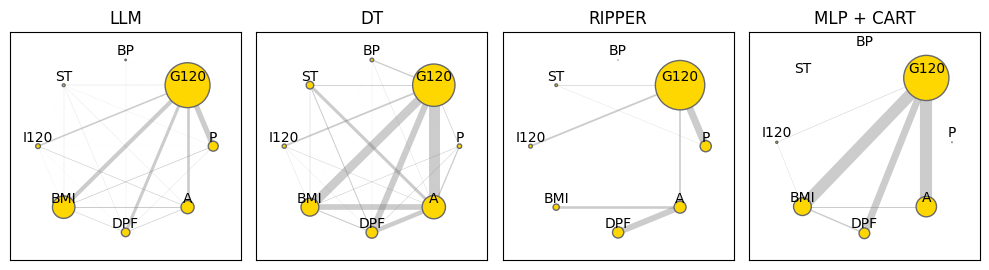

In [80]:
# import data
feat_names_code = ["P", "G120", "BP", "ST", "I120", "BMI", "DPF", "A"]

fig, axes = plt.subplots(1, 4, figsize=(10, 2.8))
plot_adj_graph(llm_adj_pima, axes[0], feat_names_code, nudgeval=0.1)
plot_adj_graph(dt_adj_pima, axes[1], feat_names_code)
plot_adj_graph(rip_adj_pima, axes[2], feat_names_code)
plot_adj_graph(mlp_adj_pima, axes[3], feat_names_code)

axes[0].set_title("LLM")
axes[1].set_title("DT")
axes[2].set_title("RIPPER")
axes[3].set_title("MLP + CART")

for i in range(4): 
    axes.flatten()[i].margins(0.1)
    
plt.tight_layout()
plt.show()
#plt.savefig("PIMA_models_log.pdf")
#plt.savefig("PIMA_models_log.png", dpi = 300)

### GRAPH DISTANCE

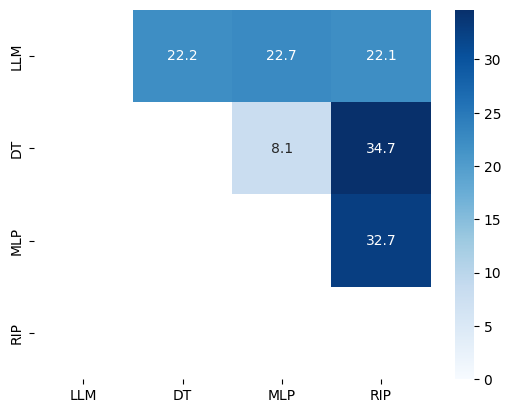

In [33]:
# frobenius norm
model_names = ["LLM", "DT", "MLP", "RIP"]
adjs = [llm_adj_pima, dt_adj_pima, mlp_adj_pima, rip_adj_pima]
diff = np.empty((len(adjs), len(adjs)))
diff[:] = np.nan
for i in range(len(adjs)):
    for j in range(i+1,len(adjs)):    
        diff[i,j] = np.sqrt(np.sum(np.square(adjs[i] - adjs[j])))
        
sns.heatmap(diff, cmap = sns.color_palette("Blues", as_cmap=True), vmin = 0, annot=True, 
            fmt=".1f", xticklabels = model_names, yticklabels = model_names)
plt.show()

In [27]:
#plot differences
#sns.heatmap(dt_adj_pima-rip_adj_pima, cmap = sns.diverging_palette(220, 20, as_cmap=True), vmin = -5, vmax = 5,
#           xticklabels = feat_names, yticklabels = feat_names)

### PIMA over-fit analysis

In [35]:
# define the hyperparameter grid for each model
param_grid = {
                'max_depth': [None, 5, 10, 15, 20],
                'min_samples_split': [5, 10, 20],
                'min_samples_leaf': [5, 10] 
              }

all_adj_pima_depth = []
imp_all = np.zeros((len(feat_names), nfolds, 4))
cent_all = np.zeros((len(feat_names), 4))
for d, depth in enumerate([6,9,12,15]):
    print("depth", depth)
    adj_all = np.zeros((len(feat_names), len(feat_names)))
    for rr, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        train, test = df.iloc[train_idx][list(feat_names) + ["target"]], df.iloc[test_idx][list(feat_names) + ["target"]]
        train["target"] = train["target"].astype("str")
        test["target"] = test["target"].astype("str")
        best_model = DecisionTreeClassifier(random_state=123, max_depth = depth).fit(X_train, y_train)
        print(f"Accuracy = {best_model.score(X_test, y_test):.2f}")
        parsed_rules = traverse_tree(best_model, feat_names, best_model.classes_)
        rules_text = export_text(best_model, feature_names=feat_names)
        # build graph
        rule_rels, var_rels = get_relevances(parsed_rules, train, feat_names)
        adj_all += get_adj(var_rels[cond_type], rule_rels[rule_type])
        imp_all[:,rr,d] = best_model.feature_importances_
    adj = adj_all/nfolds
    cent_all[:,i] = adj.mean(axis=1)
    all_adj_pima_depth.append(adj)  

depth 6
Accuracy = 0.77
Accuracy = 0.73
Accuracy = 0.75
Accuracy = 0.71
Accuracy = 0.63
depth 9
Accuracy = 0.75
Accuracy = 0.73
Accuracy = 0.71
Accuracy = 0.71
Accuracy = 0.65
depth 12
Accuracy = 0.71
Accuracy = 0.71
Accuracy = 0.71
Accuracy = 0.73
Accuracy = 0.65
depth 15
Accuracy = 0.71
Accuracy = 0.72
Accuracy = 0.74
Accuracy = 0.73
Accuracy = 0.63


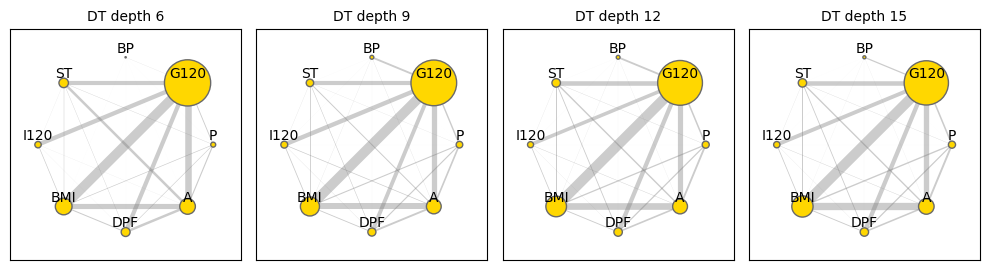

In [81]:
fig, axes = plt.subplots(1, 4, figsize=(10, 2.8))
for i, adj in enumerate(all_adj_pima_depth): 
    plot_adj_graph(adj, axes.flatten()[i], feat_names_code)
    axes.flatten()[i].margins(0.1)
    axes.flatten()[i].set_title(f"DT depth {[6,9,12,15][i]}" , fontsize = 10)
plt.tight_layout()
plt.show()
#plt.savefig("PIMA-overfit.pdf")
#plt.savefig("PIMA-overfit.png", dpi = 300)

In [44]:
# compute Gini importance robustness
pd.DataFrame(imp_all.mean(axis = 1)).corr(method='spearman').to_numpy().mean().round(3) 

0.943

In [45]:
# compute centrality importance robustness
pd.DataFrame(cent_all).corr(method='spearman').to_numpy().mean().round(3) 

0.976

## BREAST DATASET - CLASS SPECIFIC

In [97]:
df_name = "BREAST"
df = pd.read_csv(f"LLM-outputs/{df_name}.csv")
df["target"] = df["Outcome"].astype("str")
feat_names = df.columns[:np.where(np.array(df.columns)=="Outcome")[0][0]]
X = df[feat_names].values
y = df["target"].values

In [100]:
# generating data for LLM
for rr, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    train, test = df.iloc[train_idx][list(feat_names) + ["target"]], df.iloc[test_idx][list(feat_names) + ["target"]]
    pd.concat((train, test)).to_csv(f"LLM-outputs/{df_name}_CV{rr}.csv", index = False) 

In [111]:
adj_all = np.zeros((len(feat_names), len(feat_names)))
adj_all_sub = {target: np.zeros((len(feat_names), len(feat_names))) for target in df["target"].unique()}
df_name = "BREAST"

for rr in range(nfolds):
    df = pd.read_csv(f"LLM-outputs/{df_name}_CV{rr}.csv") 
    train = df.loc[:round(len(df)*0.8)]
    train["target"] = train["target"].astype("str")
    rules_df = pd.read_csv(f"LLM-outputs/{df_name}_res_CV{rr}_rules.csv", header = None)
    parsed_rules = [parse_llm_rules(rule) for rule in rules_df[0]]
    # generate graph for all classes
    rule_rels, var_rels = get_relevances(parsed_rules, train, feat_names)
    adj_all += get_adj(var_rels[cond_type], rule_rels[rule_type])

    # generate graph for each target class
    for target in df["target"].unique():
        parsed_rules_sub = [rule for rule in parsed_rules if rule["outcome"] == target]
        rule_rels, var_rels = get_relevances(parsed_rules_sub, train, feat_names)
        adj = get_adj(var_rels[cond_type], rule_rels[rule_type])
        adj_all_sub[target] += adj/adj.sum().sum()*100
        
adj = adj_all/nfolds
adj_all_sub_llm = {target: adj_all_sub[target]/nfolds for target in adj_all_sub}

In [117]:
classes = ["Carcinoma", "Fibro-adenoma", "Mastopathy", "Glandular", "Connective", "Adipose"]
feat_names_codes = ["I0", "PA500", "HFS", "DA", "AREA", "A/DA", "MAXIP", "DR", "P"]

In [115]:
def plot_adj_graph(adj, ax, feat_names=None, color="gold", nudgeval=0.1):
    adj1 = adj.copy()
    centrality = adj1.sum(axis=1)
    np.fill_diagonal(adj1, 0)
    
    # Create the graph
    G = nx.from_numpy_array(adj1)
    
    node_sizes = [15 * centrality[node] for node in G.nodes()]
    
    if feat_names is None:
        labels = {i: i for i in G.nodes()}
    else:
        labels = {i: feat_names[i] for i in G.nodes()}
    
    pos = nx.circular_layout(G)  # positions for all nodes
    pos_labels = nudge(pos, 0, nudgeval) 
    
    # Plot nodes
    nodes = nx.draw_networkx_nodes(G, pos, ax=ax, node_size=np.array(node_sizes), node_color=color)
    nodes.set_edgecolor('dimgray')
    
    # Plot edges if there are any
    if G.number_of_edges() > 0:
        edges, weights = zip(*nx.get_edge_attributes(G, 'weight').items())
        nx.draw_networkx_edges(G, pos, ax=ax, edgelist=edges, width=np.array(weights), edge_color='gray', alpha=0.4)
    
    # Plot labels
    nx.draw_networkx_labels(G, pos_labels, labels, font_size=10.5, font_family="sans-serif", ax=ax)

In [118]:
palette = sns.color_palette("pastel")

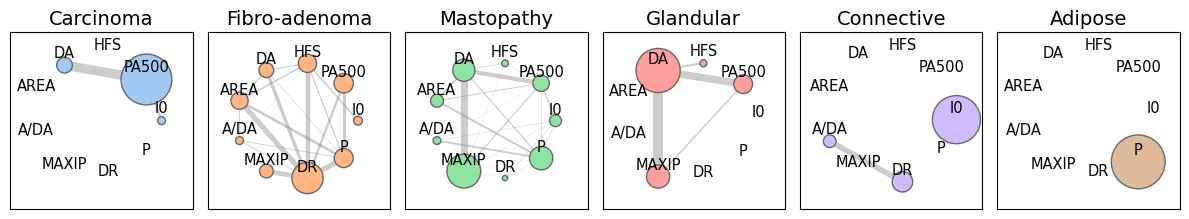

In [126]:
fig, axes = plt.subplots(1, 6, figsize=(12, 2.3))
for t, target in enumerate(df["target"].unique()): 
    plot_adj_graph(adj_all_sub_llm[target], axes.flatten()[t], feat_names_codes, palette[t], 0.2)
    axes.flatten()[t].set_title(classes[t], fontsize = 14)
    axes.flatten()[t].margins(0.2)   
plt.tight_layout()
plt.show()
#plt.savefig("llm_class_graph.pdf")
#plt.savefig("llm_class_graph.png", dpi = 300)

In [129]:
# define the hyperparameter grid for each model
param_grid = {
                'max_depth': [None, 5, 10, 15, 20],
                'min_samples_split': [5, 10, 20],
                'min_samples_leaf': [5, 10] 
              }

adj_all = np.zeros((len(feat_names), len(feat_names)))
adj_all_sub = {target: np.zeros((len(feat_names), len(feat_names))) for target in df["target"].unique()}
for rr, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    train, test = df.iloc[train_idx][list(feat_names) + ["target"]], df.iloc[test_idx][list(feat_names) + ["target"]]

    predictor = GridSearchCV( estimator=DecisionTreeClassifier(random_state=123), 
        param_grid=param_grid, refit=True, cv=inner_cv, n_jobs=-1 ).fit(X_train, y_train)
    best_params = predictor.best_params_
    best_model = predictor.best_estimator_
    print(f"Accuracy = {predictor.score(X_test, y_test):.2f}")
    #rules_text = export_text(best_model, feature_names=feat_names)
    parsed_rules = traverse_tree(best_model, feat_names, best_model.classes_)
    rule_rels, var_rels = get_relevances(parsed_rules, train, feat_names)
    adj_all += get_adj(var_rels[cond_type], rule_rels[rule_type])

    for target in df["target"].unique():
        parsed_rules_sub = [rule for rule in parsed_rules if rule["outcome"] == target]
        rule_rels, var_rels = get_relevances(parsed_rules_sub, train, feat_names)
        adj = get_adj(var_rels[cond_type], rule_rels[rule_type])
        adj_all_sub[target] += adj/adj.sum().sum()*100
adj = adj_all/nfolds
adj_all_sub_dt = {target: adj_all_sub[target]/nfolds for target in adj_all_sub}

Accuracy = 0.59
Accuracy = 0.76
Accuracy = 0.71
Accuracy = 0.67
Accuracy = 0.67


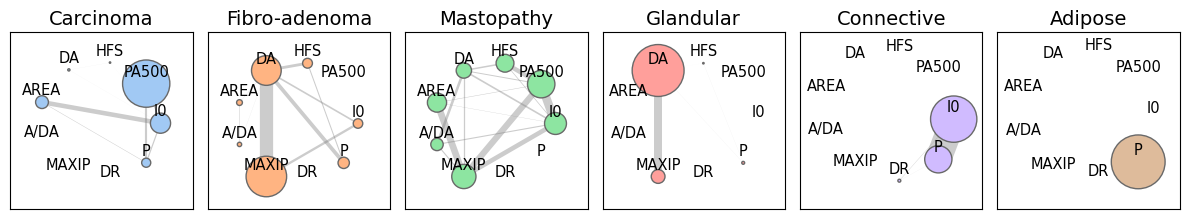

In [131]:
fig, axes = plt.subplots(1, 6, figsize=(12, 2.3))
for t, target in enumerate(df["target"].unique()): 
    plot_adj_graph(adj_all_sub_dt[target], axes.flatten()[t], feat_names_codes, palette[t], 0.2)
    axes.flatten()[t].set_title(classes[t], fontsize = 14)
    axes.flatten()[t].margins(0.2)   
plt.tight_layout()
plt.show()
#plt.savefig("dt_class_graph.pdf")
#plt.savefig("dt_class_graph.png", dpi = 300)

# FEATURE IMPORTANCE VALIDATION

### TRAIN DECISION TREE ON 15 BENCHMARK DATASETS

In [24]:
# datasets from PMLB (larger)
sel1 = ["Hill_Valley_with_noise", "hypothyroid", "mfeat_pixel", "tokyo1"]
# datasets from UCIREPO (smaller)
sel2 = ["Balance Scale", "Breast Cancer", "Breast Cancer Wisconsin (Original)", 
        "Breast Cancer Wisconsin (Prognostic)", "Breast Cancer Wisconsin (Diagnostic)", 
        "Car Evaluation", "Contraceptive Method Choice", "Hepatitis", "SPECT Heart", 
        "Waveform Database Generator (Version 1)", "Zoo"]
# all datasets
sel_df_names = sel1 + sel2

In [25]:
# perform nested cross-validation
outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid = {
             'criterion': ['gini', 'entropy'],
             'max_depth': np.linspace(4,30,13).astype(int),
             }

In [ ]:
# train on PMLB datasets
for df_name in sel1:
    print(df_name)
    df = fetch_data(df_name, return_X_y = False)
    X, y = fetch_data(df_name, return_X_y = True)
    feat_names = df.columns[:-1]      
    all_imp = pd.DataFrame(columns=["method", "fold"] + list(feat_names))
    all_scores = pd.DataFrame(columns=["method", "fold", "selected", "metric", "value"])
    
    for rr, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        train, test = df.iloc[train_idx], df.iloc[test_idx]
        
        predictor = GridSearchCV(estimator=DecisionTreeClassifier(random_state=123), 
            param_grid=param_grid, refit=True, cv=inner_cv, n_jobs=-1 ).fit(X_train, y_train)
        best_params = predictor.best_params_
        best_model = predictor.best_estimator_
        print(f"Accuracy = {predictor.score(X_test, y_test):.2f}")
        # Extract rules
        rules = traverse_tree(best_model, feat_names, best_model.classes_)
        
        # Permutation importance
        perm_imp = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1).importances_mean
        all_imp.loc[len(all_imp)] = ["perm", rr] + list(perm_imp / sum(perm_imp))    
        
        # Gini importance
        gini_imp = best_model.feature_importances_
        all_imp.loc[len(all_imp)] = ["gini", rr] + list(gini_imp / sum(gini_imp))
        
        # SHAP importance
        explainer = shap.TreeExplainer(best_model, X_train)
        shap_values = explainer(X_test)
        shap_imp = np.abs(shap_values.values).mean(axis=0).mean(axis=1)
        all_imp.loc[len(all_imp)] = ["shap", rr] + list(shap_imp / sum(shap_imp))
        
        # Get relevances
        rule_rels, var_rels = get_relevances(rules, train, feat_names)
        for cond_type in ["impurity", "relevance"]:
            for rule_type in ["support", "confidence", "lift", "equal", "relevance"]:
                # centrality
                adj = get_adj(var_rels[cond_type], rule_rels[rule_type])
                net_imp = adj.sum(axis=1)
                ss = f"{rule_type}_{cond_type}_centrality"
                all_imp.loc[len(all_imp)] = [ss, rr] + list(net_imp / sum(net_imp))
     
        # compute importance
        for index, row in all_imp[all_imp["fold"]==rr].iterrows():
            method = row["method"]
            imp_vals = np.array(row[feat_names])
            imp_sorted = feat_names[np.flip(np.argsort(imp_vals))]
            for k in range(2,20):    
                XX_train, XX_test = train[imp_sorted[:k]], test[imp_sorted[:k]]
                predictor = DecisionTreeClassifier(random_state=123, **best_params).fit(XX_train, y_train)
                y_pred = predictor.predict(XX_test)
                all_scores.loc[len(all_scores)] = [method, rr, k, "A", accuracy_score(y_test, y_pred)]  
                all_scores.loc[len(all_scores)] = [method, rr, k, "MCC", matthews_corrcoef(y_test, y_pred)] 
    all_scores.to_csv(f"{df_name}_scores.csv")
    all_imp.to_csv(f"{df_name}_imps.csv")

In [ ]:
# train on UCIREPO datasets
for df_name in sel2:
    data = fetch_ucirepo(name=df_name)
    df_name = data["metadata"]["name"]
    print(id, df_name)
    X_df = data.data.features
    y_df = data.data.targets
    df = X_df.copy()
    df = pd.get_dummies(df, dtype=float)
    df["target"] = y_df
    feat_names = df.columns[:-1]  
    X = df[feat_names].values
    y = df["target"].values  
    all_imp = pd.DataFrame(columns=["method", "fold"] + list(feat_names))
    all_scores = pd.DataFrame(columns=["method", "fold", "selected", "metric", "value"])
    
    for rr, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        train, test = df.iloc[train_idx], df.iloc[test_idx]
        
        predictor = GridSearchCV(estimator=DecisionTreeClassifier(random_state=123), 
            param_grid=param_grid, refit=True, cv=inner_cv, n_jobs=-1 ).fit(X_train, y_train)
        best_params = predictor.best_params_
        best_model = predictor.best_estimator_
        print(f"Accuracy = {predictor.score(X_test, y_test):.2f}")
        # Extract rules
        rules = traverse_tree(best_model, feat_names, best_model.classes_)
        
        # Permutation importance
        perm_imp = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1).importances_mean
        all_imp.loc[len(all_imp)] = ["perm", rr] + list(perm_imp / sum(perm_imp))    
        
        # Gini importance
        gini_imp = best_model.feature_importances_
        all_imp.loc[len(all_imp)] = ["gini", rr] + list(gini_imp / sum(gini_imp))
        
        # SHAP importance
        explainer = shap.TreeExplainer(best_model, X_train)
        shap_values = explainer(X_test)
        shap_imp = np.abs(shap_values.values).mean(axis=0).mean(axis=1)
        all_imp.loc[len(all_imp)] = ["shap", rr] + list(shap_imp / sum(shap_imp))
        
        # Get relevances
        rule_rels, var_rels = get_relevances(rules, train, feat_names)
        for cond_type in ["impurity", "relevance"]:
            for rule_type in ["support", "confidence", "lift", "equal", "relevance"]:
                # centrality
                adj = get_adj(var_rels[cond_type], rule_rels[rule_type])
                net_imp = adj.sum(axis=1)
                ss = f"{rule_type}_{cond_type}_centrality"
                all_imp.loc[len(all_imp)] = [ss, rr] + list(net_imp / sum(net_imp))       
        
        # compute importance
        for index, row in all_imp[all_imp["fold"]==rr].iterrows():
            method = row["method"]
            imp_vals = np.array(row[feat_names])
            imp_sorted = feat_names[np.flip(np.argsort(imp_vals))]
            for k in range(2,20):    
                XX_train, XX_test = train[imp_sorted[:k]], test[imp_sorted[:k]]
                predictor = DecisionTreeClassifier(random_state=123, **best_params).fit(XX_train, y_train)
                y_pred = predictor.predict(XX_test)
                all_scores.loc[len(all_scores)] = [method, rr, k, "A", accuracy_score(y_test, y_pred)]  
                all_scores.loc[len(all_scores)] = [method, rr, k, "MCC", matthews_corrcoef(y_test, y_pred)] 
    all_scores.to_csv(f"{df_name}_scores.csv")
    all_imp.to_csv(f"{df_name}_imps.csv")

### PERFORMANCE ANALYSIS

In [22]:
selected_methods = ['perm', 'gini', 'shap', 'relevance_relevance_centrality']

In [27]:
all_stats = {}
k = 5
for df_name in sel_df_names:
    all_scores = pd.read_csv(f"{df_name}_scores.csv", index_col = 0)
    all_imp = pd.read_csv(f"{df_name}_imps.csv", index_col = 0)
    all_stats[df_name]=(all_scores[(all_scores["selected"]==k) & (all_scores["metric"]=="A")].groupby("method")["value"].mean())
    #.sort_values(by = "A", ascending = False)
all_stats_df = pd.DataFrame(all_stats).T[selected_methods]
all_stats_df.columns = ["perm", "gini", "shap", "cent"]
all_stats_df["rank"] = all_stats_df.T.rank(ascending = False).loc["cent"]
#all_stats_df.round(4)

In [28]:
# performance analysis
all_stats2 = {}
k = 10
for df_name in sel_df_names:
    all_scores = pd.read_csv(f"{df_name}_scores.csv", index_col = 0)
    all_stats2[df_name]=(all_scores[(all_scores["selected"]==k) & (all_scores["metric"]=="A")].groupby("method")["value"].mean())
    #.sort_values(by = "A", ascending = False)
all_stats_df2 = pd.DataFrame(all_stats2).T[selected_methods]
all_stats_df2.columns = ["perm", "gini", "shap", "cent"]
#all_stats_df2["rank"] = all_stats_df2.T.rank(ascending = False).loc["cent"]

In [29]:
pd.concat([all_stats_df,all_stats_df2], axis = 1).round(3)

,perm,gini,shap,cent,rank,perm,gini,shap,cent
Hill_Valley_with_noise,0.541,0.527,0.540,0.554,1.0,0.535,0.541,0.554,0.551
hypothyroid,0.979,0.974,0.975,0.975,2.0,0.977,0.977,0.974,0.977
mfeat_pixel,0.634,0.640,0.633,0.650,1.0,0.807,0.852,0.836,0.826
tokyo1,0.916,0.913,0.911,0.916,1.0,0.912,0.899,0.902,0.904
Balance Scale,0.789,0.789,0.787,0.789,2.0,0.789,0.789,0.787,0.789
Breast Cancer,0.693,0.724,0.731,0.735,1.0,0.697,0.725,0.707,0.711
Breast Cancer Wisconsin (Original),0.950,0.944,0.944,0.947,2.0,0.941,0.944,0.941,0.944
Breast Cancer Wisconsin (Prognostic),0.737,0.727,0.722,0.718,4.0,0.717,0.707,0.712,0.727
Breast Cancer Wisconsin (Diagnostic),0.935,0.937,0.930,0.928,4.0,0.924,0.923,0.928,0.921
Car Evaluation,0.819,0.815,0.823,0.825,1.0,0.924,0.922,0.919,0.926


### ROBUSTNESS ANALYSIS

In [30]:
# performance analysis
all_rob = {}
for df_name in sel_df_names:
    all_imp = pd.read_csv(f"{df_name}_imps.csv", index_col = 0)
    df = all_imp.copy()
    correlations = {}
    for method in selected_methods:#df['method'].unique():
        method_df = df[df['method'] == method]
        correlations[method] = method_df.drop(columns = ["method", "fold"]).T.corr(method='spearman').to_numpy().mean() 
    all_rob[df_name] = correlations

In [31]:
all_rob_df = pd.DataFrame(all_rob).T[selected_methods]
all_rob_df.columns = ["perm", "gini", "shap", "cent"]
#all_rob_df["rank"] = all_rob_df.T.rank(ascending = False).loc["cent"]
all_rob_df.round(3)

,perm,gini,shap,cent
Hill_Valley_with_noise,0.114,0.246,0.251,0.247
hypothyroid,0.656,0.892,0.889,0.892
mfeat_pixel,0.374,0.338,0.334,0.336
tokyo1,0.315,0.424,0.414,0.450
Balance Scale,0.076,0.112,0.048,0.068
Breast Cancer,0.133,0.383,0.398,0.405
Breast Cancer Wisconsin (Original),0.637,0.757,0.725,0.752
Breast Cancer Wisconsin (Prognostic),0.098,0.403,0.397,0.421
Breast Cancer Wisconsin (Diagnostic),0.314,0.375,0.361,0.360
Car Evaluation,0.794,0.814,0.795,0.742
